In [31]:
!pip install -q --upgrade keras-cv
!pip install -q --upgrade keras  # Upgrade to Keras 3.

In [ ]:
import tensorflow as tf
import keras_cv
from tensorflow.keras.optimizers import RMSprop, Adam, AdamW
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#dir_path = "/content/drive/MyDrive/Cases/Original Image Datasets/Animal"
dir_path = "/content/drive/MyDrive/Cases/Small Image Datasets/Animal Classification"

Train and validation Data generator

In [ ]:
BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)
train_generator = tf.keras.utils.image_dataset_from_directory(
    directory=dir_path,  color_mode='rgb',label_mode='int',
    image_size=IMAGE_SIZE,batch_size=BATCH_SIZE, shuffle=True,subset='training',validation_split=0.2,
    seed=25)
validation_generator = tf.keras.utils.image_dataset_from_directory(
    directory=dir_path, color_mode='rgb',
    label_mode='int',image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,shuffle=False,subset='validation',validation_split=0.2,
    seed=25)

Found 1944 files belonging to 15 classes.
Using 1556 files for training.
Found 1944 files belonging to 15 classes.
Using 388 files for validation.


In [117]:
class_names = train_generator.class_names
print(class_names)

['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']


In [118]:
len(class_names)

15

In [ ]:
train_ds_shuff = train_generator.shuffle(
    3*BATCH_SIZE, reshuffle_each_iteration=True
)
images = next(iter(train_ds_shuff.take(1)))[0]
images.shape

TensorShape([16, 224, 224, 3])

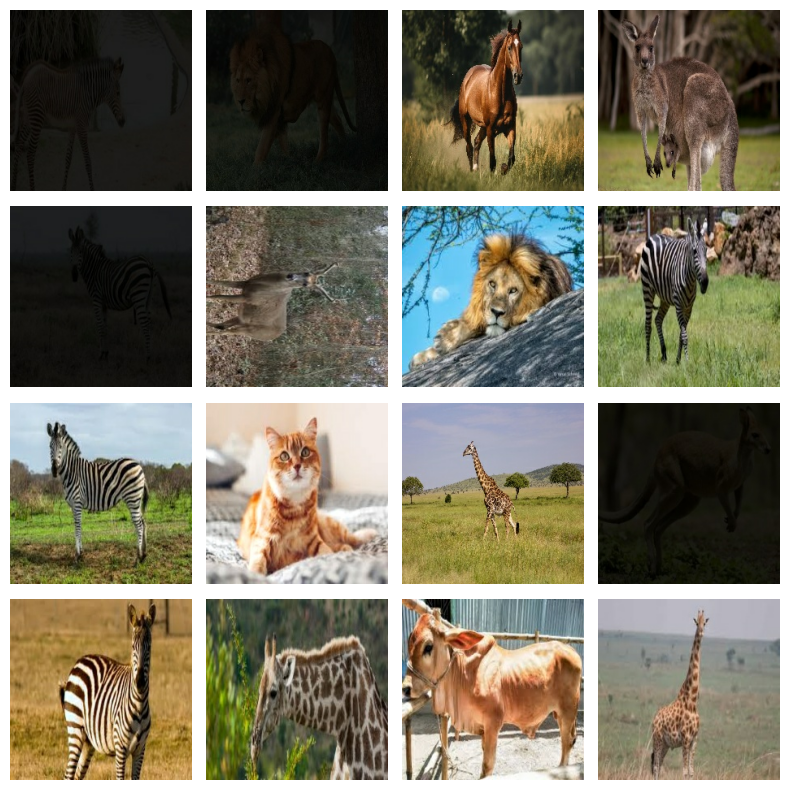

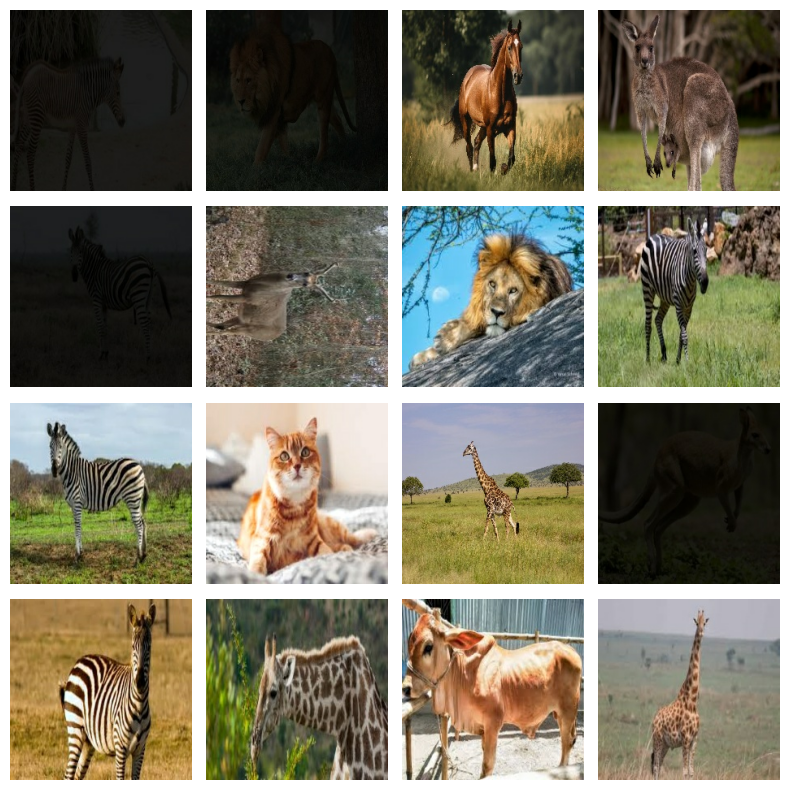

In [120]:
keras_cv.visualization.plot_image_gallery(images, value_range=(0, 255))

In [121]:
keras.backend.clear_session()

Images scaling

In [122]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_train_ds = train_generator.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds = validation_generator.map(lambda x, y: (normalization_layer(x), y))

Preparing model

In [123]:
print(keras_cv.models.ImageClassifier.presets.keys())

dict_keys(['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnet18_v2', 'resnet34_v2', 'resnet50_v2', 'resnet101_v2', 'resnet152_v2', 'mobilenet_v3_small', 'mobilenet_v3_large', 'csp_darknet_tiny', 'csp_darknet_s', 'csp_darknet_m', 'csp_darknet_l', 'csp_darknet_xl', 'efficientnetv1_b0', 'efficientnetv1_b1', 'efficientnetv1_b2', 'efficientnetv1_b3', 'efficientnetv1_b4', 'efficientnetv1_b5', 'efficientnetv1_b6', 'efficientnetv1_b7', 'efficientnetv2_s', 'efficientnetv2_m', 'efficientnetv2_l', 'efficientnetv2_b0', 'efficientnetv2_b1', 'efficientnetv2_b2', 'efficientnetv2_b3', 'densenet121', 'densenet169', 'densenet201', 'efficientnetlite_b0', 'efficientnetlite_b1', 'efficientnetlite_b2', 'efficientnetlite_b3', 'efficientnetlite_b4', 'yolo_v8_xs_backbone', 'yolo_v8_s_backbone', 'yolo_v8_m_backbone', 'yolo_v8_l_backbone', 'yolo_v8_xl_backbone', 'vitdet_base', 'vitdet_large', 'vitdet_huge', 'videoswin_tiny', 'videoswin_small', 'videoswin_base', 'resnet50_imagenet', 'resnet50_v

In [ ]:
model = keras_cv.models.ImageClassifier.from_preset(
    "resnet50_v2_imagenet", num_classes=len(class_names)
)

In [ ]:
model.compile(optimizer=AdamW(learning_rate=0.001),loss='sparse_categorical_crossentropy',
              metrics = ['acc'])

In [126]:
model.summary()

Model: "image_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net50v2_backbone                 │ (None, None, None, 2048)    │      23,564,800 │
│ (ResNetV2Backbone)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avg_pool (GlobalAveragePooling2D)    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 15)                  │          30,735 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,595,535 (90.01 MB)

 Trainable params: 23,550,095 (89.84 MB)

 Non-trainable params: 45,440 (177.50 KB)

Model Training

In [ ]:
checkpoint_filepath = 'model/weights-improvement-{epoch:02}-{val_loss:.4f}.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                     filepath=checkpoint_filepath,
                     verbose=2, monitor='val_acc', mode='max',
                     save_best_only=True
                 )

In [127]:
r = model.fit(normalized_train_ds,
              validation_data=normalized_test_ds, callbacks=[model_checkpoint_callback],
              epochs=100)

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - acc: 0.5904 - loss: 1.4325
Epoch 1: val_acc improved from -inf to 0.00000, saving model to model/weights-improvement-01-2.5950.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 79s 680ms/step - acc: 0.5917 - loss: 1.4280 - val_acc: 0.0000e+00 - val_loss: 2.5950
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - acc: 0.8679 - loss: 0.4518
Epoch 2: val_acc improved from 0.00000 to 0.00258, saving model to model/weights-improvement-02-6.0997.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - acc: 0.8680 - loss: 0.4515 - val_acc: 0.0026 - val_loss: 6.0997
Epoch 3/100
97/98 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - acc: 0.9301 - loss: 0.2591
Epoch 3: val_acc did not improve from 0.00258
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - acc: 0.9300 - loss: 0.2590 - val_acc: 0.0000e+00 - val_loss: 3.0144
Epoch 4/100
97/98 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - acc: 0.9110 - loss: 0.2978
Epoch 4: val_acc did not improve from 0.00258
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step

In [64]:
checkpoint_filepath

'model/weights-improvement-{epoch:02}-{val_loss:.4f}.keras'

In [128]:
model.load_weights("model/weights-improvement-76-0.0103.keras")

Model Evaluation

In [129]:
logloss, acc = model.evaluate(normalized_test_ds)
print("Accuracy: ", acc)
print("Logloss: ", logloss)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - acc: 0.9979 - loss: 0.0087
Accuracy:  0.9974227547645569
Logloss:  0.010325044393539429


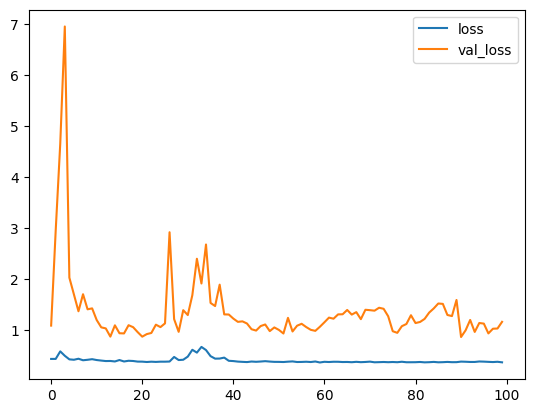

In [67]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

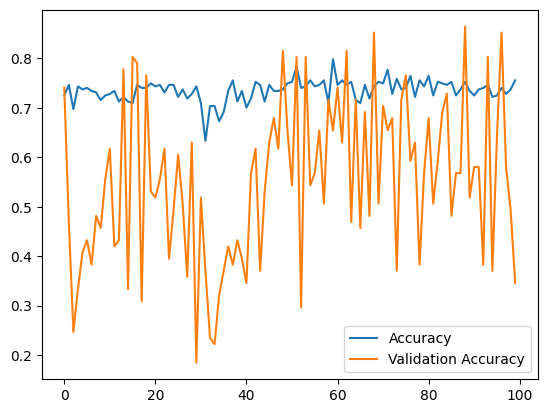

In [68]:
plt.plot(r.history['acc'], label='Accuracy')
plt.plot(r.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Load the image
#path = "/content/drive/MyDrive/Cases/Original Image Datasets/Animal/Lion/Lion_4_1.jpg"
path = "/content/drive/MyDrive/Cases/Original Image Datasets/Animal/Cow/Cow_11_1.jpg"
image = Image.open(path)

# Convert the image to a numpy array
image = np.array(image)

# Normalize the image
image = image / 255.0

# Add a batch dimension
image = np.expand_dims(image, axis=0)

In [131]:
resizing = keras_cv.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)

In [132]:
np_im_rs = resizing(image)
np_im_rs.shape

(1, 224, 224, 3)

Let's look at how our model performs after the fine tuning:

In [133]:
predictions = model.predict(np_im_rs)
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[1.1989943e-07, 2.8610611e-04, 1.6131737e-07, 9.9963140e-01,
        1.8120942e-05, 9.7968905e-07, 3.2324298e-08, 1.8268945e-06,
        8.7615526e-08, 1.3217803e-08, 5.0500387e-07, 1.5304286e-06,
        1.1015381e-06, 3.4352922e-07, 5.7782370e-05]], dtype=float32)

In [134]:
print("Top class is:", class_names[np.argmax(predictions[0])])

Top class is: Cow


In [135]:
model.save_weights('/content/drive/MyDrive/Cases/Small Image Datasets/anim_class_model.weights.h5')